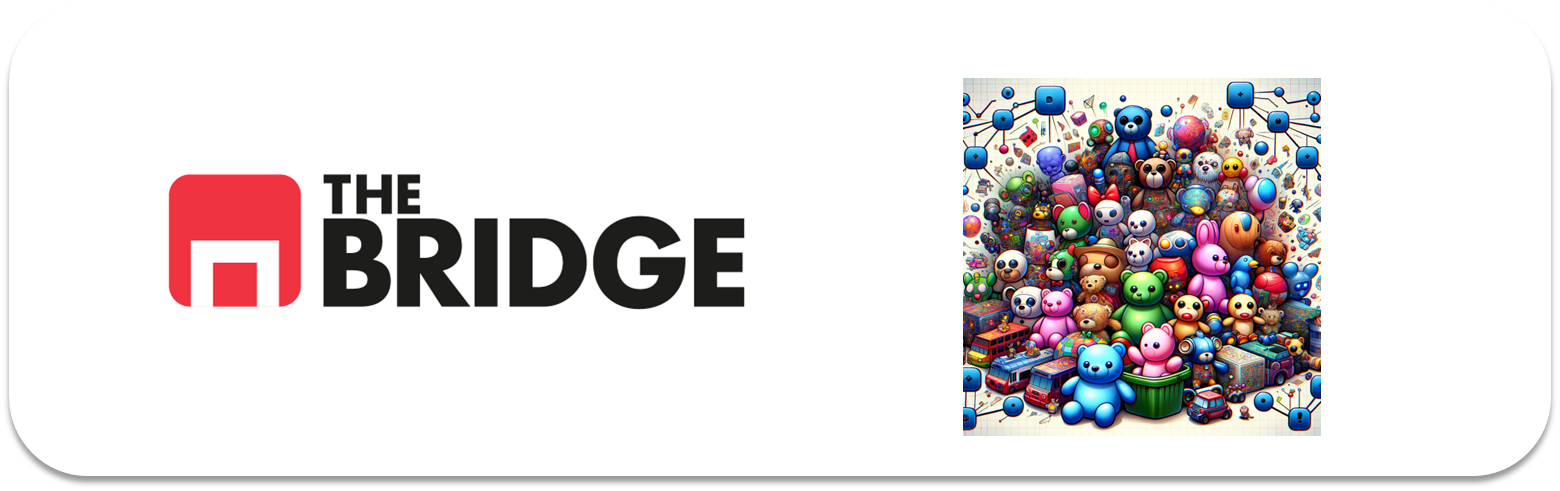

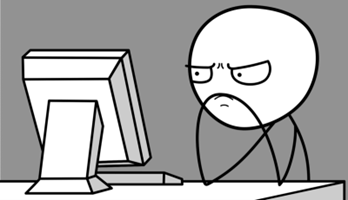

## PRACTICA OBLIGATORIA: K-MEANS

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.preprocessing import MinMaxScaler
import sklearn.datasets
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from matplotlib.ticker import FixedLocator, FixedFormatter
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [24]:
olivetti = sklearn.datasets.fetch_olivetti_faces()
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [25]:
# Mostrar el target
print("Target:")
print(olivetti.target)

# Crear un DataFrame con las imágenes y el target
df = pd.DataFrame(olivetti.data)
df['target'] = olivetti.target

# Reordenar aleatoriamente el DataFrame
df_reordenado = df.sample(frac=1, random_state=42)  # Reordenar con semilla para reproducibilidad

# Mostrar las primeras filas del DataFrame reordenado
print("\nDataFrame reordenado:")
print(df_reordenado.head())


Target:
[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28
 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 31
 31 31 31 31 31 31 31 31 32 32 32 32 32 32 

### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [26]:
# Calculamos los tamaños para cada conjunto
n_total_samples = len(df_reordenado)
n_train_samples = int(0.8 * n_total_samples)
n_validation_samples = int(0.1 * n_total_samples)
n_test_samples = n_total_samples - n_train_samples - n_validation_samples

# División de los datos
X_train = df_reordenado.drop(columns=['target']).iloc[:n_train_samples]
X_valid = df_reordenado.drop(columns=['target']).iloc[n_train_samples:n_train_samples + n_validation_samples]
X_test = df_reordenado.drop(columns=['target']).iloc[-n_test_samples:]

# Mostrar las formas de los conjuntos de datos resultantes
print("Forma del conjunto de entrenamiento:", X_train.shape)
print("Forma del conjunto de validación:", X_valid.shape)
print("Forma del conjunto de prueba:", X_test.shape)

Forma del conjunto de entrenamiento: (320, 4096)
Forma del conjunto de validación: (40, 4096)
Forma del conjunto de prueba: (40, 4096)


### #1.4

Crea los pares X,y para train, validation y test.

In [27]:
# Crear un conjunto de entrenamiento con pares X, y
train_data = X_train.copy()
train_data['target'] = 0

# Crear un conjunto de validación con pares X, y
val_data = X_valid.copy()
val_data['target'] = 0

# Crear un conjunto de prueba con pares X, y
test_data = X_test.copy()
test_data['target'] = 0

# Mostrar las primeras filas de los conjuntos de datos resultantes
print("Conjunto de entrenamiento:")
print(train_data.head())
print("\nConjunto de validación:")
print(val_data.head())
print("\nConjunto de prueba:")
print(test_data.head())


Conjunto de entrenamiento:
            0         1         2         3         4         5         6  \
209  0.198347  0.235537  0.351240  0.409091  0.421488  0.429752  0.500000   
280  0.185950  0.128099  0.115702  0.132231  0.185950  0.268595  0.433884   
33   0.508264  0.603306  0.619835  0.628099  0.657025  0.665289  0.690083   
210  0.136364  0.140496  0.185950  0.280992  0.318182  0.363636  0.409091   
93   0.652893  0.644628  0.652893  0.706612  0.714876  0.719008  0.743802   

            7         8         9  ...      4087      4088      4089  \
209  0.528926  0.524793  0.553719  ...  0.508264  0.524793  0.504132   
280  0.541322  0.570248  0.586777  ...  0.396694  0.409091  0.301653   
33   0.727273  0.743802  0.768595  ...  0.301653  0.305785  0.314050   
210  0.417355  0.438017  0.454545  ...  0.169421  0.206612  0.276859   
93   0.747934  0.747934  0.756198  ...  0.074380  0.074380  0.082645   

         4090      4091      4092      4093      4094      4095  target  
209

Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [28]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

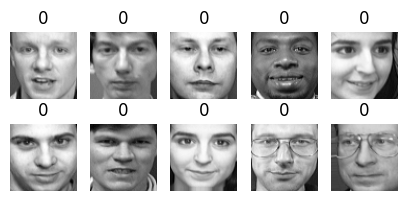

In [29]:
plot_faces(train_data.drop(columns=['target']).iloc[:10].values, train_data['target'].iloc[:10])

### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [30]:


pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

219

### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

In [31]:

best_score = -1
best_k = -1

for k in range(5, 151, 5):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    labels = kmeans.labels_
    score = silhouette_score(X_train_pca, labels)
    print(f"For k = {k}, Silhouette Score = {score}")
    if score > best_score:
        best_score = score
        best_k = k

print(f"\nBest Silhouette Score obtained with k = {best_k}: {best_score}")

For k = 5, Silhouette Score = 0.10895297676324844
For k = 10, Silhouette Score = 0.0964231863617897
For k = 15, Silhouette Score = 0.09101124107837677
For k = 20, Silhouette Score = 0.12032248824834824
For k = 25, Silhouette Score = 0.12361745536327362
For k = 30, Silhouette Score = 0.1406538188457489
For k = 35, Silhouette Score = 0.13979633152484894
For k = 40, Silhouette Score = 0.15569297969341278
For k = 45, Silhouette Score = 0.15338972210884094
For k = 50, Silhouette Score = 0.1607741415500641
For k = 55, Silhouette Score = 0.1686907559633255
For k = 60, Silhouette Score = 0.1800774484872818
For k = 65, Silhouette Score = 0.19021683931350708
For k = 70, Silhouette Score = 0.19162195920944214
For k = 75, Silhouette Score = 0.1953030824661255
For k = 80, Silhouette Score = 0.20274558663368225
For k = 85, Silhouette Score = 0.20752613246440887
For k = 90, Silhouette Score = 0.21417100727558136
For k = 95, Silhouette Score = 0.2127947360277176
For k = 100, Silhouette Score = 0.21267

### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

For k = 5, Inertia = 17169.806640625
For k = 10, Inertia = 15111.8603515625
For k = 15, Inertia = 13774.4189453125
For k = 20, Inertia = 12318.638671875
For k = 25, Inertia = 11559.75
For k = 30, Inertia = 10766.5419921875
For k = 35, Inertia = 9930.978515625
For k = 40, Inertia = 9401.3408203125
For k = 45, Inertia = 8750.806640625
For k = 50, Inertia = 8298.4189453125
For k = 55, Inertia = 7675.94287109375
For k = 60, Inertia = 7299.76025390625
For k = 65, Inertia = 6815.3212890625
For k = 70, Inertia = 6484.41650390625
For k = 75, Inertia = 6157.34375
For k = 80, Inertia = 5807.4013671875
For k = 85, Inertia = 5418.54931640625
For k = 90, Inertia = 5173.697265625
For k = 95, Inertia = 4920.30908203125
For k = 100, Inertia = 4638.81787109375
For k = 105, Inertia = 4460.6201171875
For k = 110, Inertia = 4232.470703125
For k = 115, Inertia = 3984.76708984375
For k = 120, Inertia = 3753.430419921875
For k = 125, Inertia = 3551.71826171875
For k = 130, Inertia = 3338.38134765625
For k = 

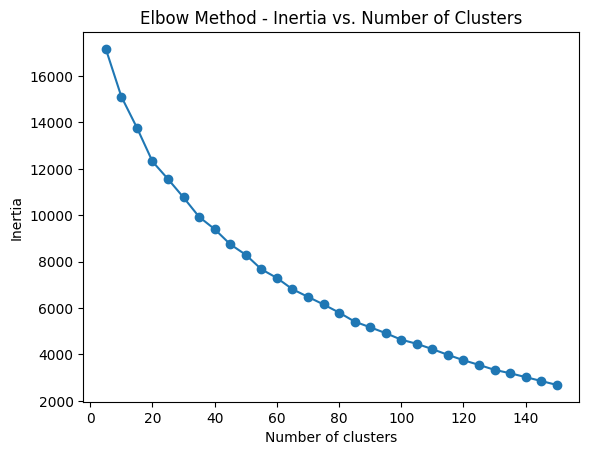

In [32]:
inertia_values = []

for k in range(5, 151, 5):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    inertia_values.append(kmeans.inertia_)
    print(f"For k = {k}, Inertia = {kmeans.inertia_}")

# Graficar la curva de la inercia
plt.plot(range(5, 151, 5), inertia_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method - Inertia vs. Number of Clusters')
plt.show()


### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

In [33]:
# Definir y ajustar el mejor modelo con el valor de k obtenido con el método de la puntuación de silueta
best_k_silhouette = best_k
best_model = KMeans(n_clusters=best_k_silhouette, random_state=42)
best_model.fit(X_train_pca)


KMeans(n_clusters=115, random_state=42)

### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?

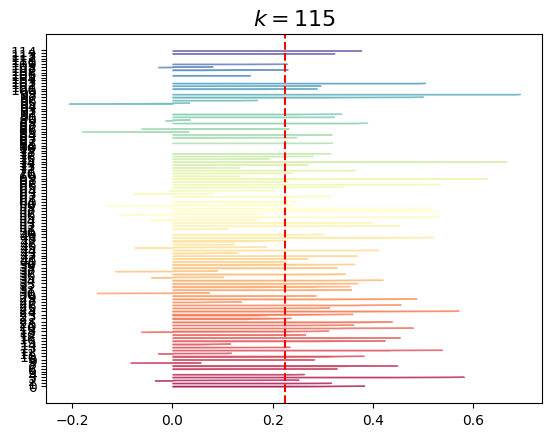

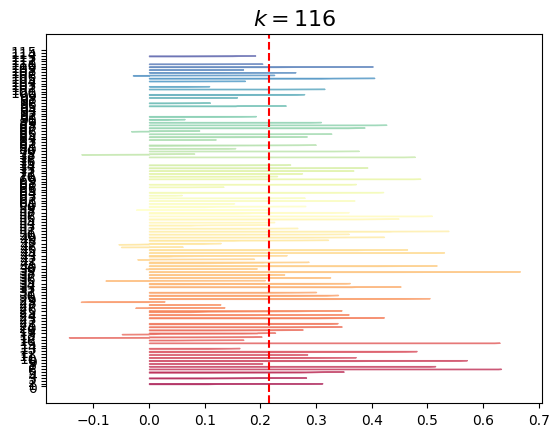

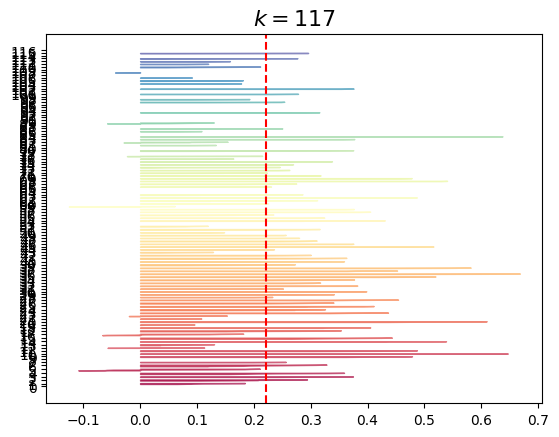

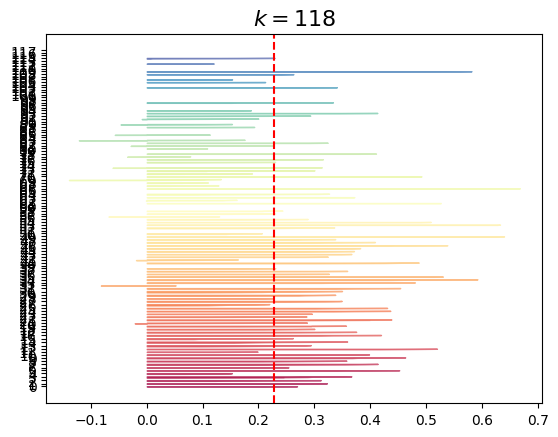

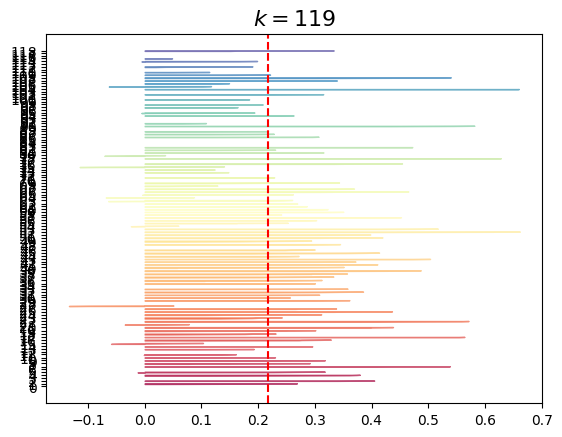

In [34]:

def plot_silhouette(clustering_model, X_data):
    silhouette_scores = []
    for k in range(115, 120):
        clustering_model.n_clusters = k
        clustering_model.fit(X_data)
        y_pred = clustering_model.labels_
        silhouette_coefficients = silhouette_samples(X_data, y_pred)
        silhouette_avg = silhouette_score(X_data, y_pred)
        silhouette_scores.append(silhouette_avg)

        padding = len(X_data) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = matplotlib.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
        if k in (3, 5):
            plt.ylabel("Cluster")
        
        if k in (5, 6):
            plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")
        else:
            plt.tick_params(labelbottom=True)

        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        plt.title("$k={}$".format(k), fontsize=16)

        plt.show()

# Usar la función para visualizar el coeficiente de silueta
plot_silhouette(best_model, X_train_pca)


## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)